##  This part is to apply DQN model on to the dataset.

In [2]:
# dueling DQN     Double DQN etc
## optimize the env

#  Dueling DQN
import gym

import preprocessing_stockenv
import preprocessing_adding_technical_indicator

import pandas as pd
import numpy as np
from collections import deque
import random
import tensorflow as tf
from tensorflow import keras
from gym.utils import seeding

In [3]:
data = preprocessing_adding_technical_indicator.add_technical_indicator()
env = preprocessing_stockenv.StockEnv(data)
obs = env.reset()

[ 1.00000e+03  0.00000e+00  0.00000e+00  2.62000e+02  0.00000e+00
 -6.66667e+01  4.69697e+01  3.16346e+05]


In [4]:
alpha0 = 1e-3 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.95 # discount factor
epsilon = 0.05
# epsilon_min = 0.01
# epsilon_decay = 0.99
input_shape = [8] # ==env.observation_space.shape
n_outputs = 3  # env.action_space.n

In [5]:
#  dueling DQN model initial
def model_initial():
    K = keras.backend
    input_states = keras.layers.Input(shape=input_shape)
    hidden1 = keras.layers.Dense(24, activation="elu")(input_states)
    hidden2 = keras.layers.Dense(24, activation="elu")(hidden1)
    state_values = keras.layers.Dense(1)(hidden2)    # state value nn

    raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
    advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
    Q_values = state_values + advantages
    model = keras.Model(inputs=[input_states], outputs=[Q_values])
    return model


In [6]:
# add some randomness to get better generalization
def epsilon_greedy_policy(obs, epsilon):  # epsilon 0.05 
    if np.random.rand() < epsilon:
        return np.random.randint(3) #  env.action_space.sample()  randomly choose from 0,1,2
    else:
        Q_values = model.predict(obs[np.newaxis])
        return np.argmax(Q_values[0])

In [7]:
# DQN can use the technic of experience replay
from collections import deque
replay_buffer = deque(maxlen=800)  # store the replay experience

# define the sample function
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size) # sample from total linked-list
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
    np.array([experience[field_index] for experience in batch])
    for field_index in range(5)]
    return states, actions, rewards, next_states, dones

# define the step of interval
def trade_time_unit(env, obs, epsilon):
    action = epsilon_greedy_policy(obs, epsilon)
    # print(action)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((obs, action, reward, next_state, done))
    return next_state, reward, done, info

batch_size = 128  # how to select
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=alpha0) #  Adam optim  not choosing decay
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size) # sample from replay
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states) #compute the target Q-Value for each experience's state-action pair
    max_next_Q_values = np.max(next_Q_values, axis =1)
    target_Q_values = (rewards + (1-dones) * discount_factor*max_next_Q_values)  # TD target
    mask = tf.one_hot(actions, n_outputs)   # filter those unwanted actions
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

#


In [8]:
model = model_initial()
# model = keras.models.load_model("DDQN_50episodes.h5", compile =False)
count = 0
for episode in range(500):
    obs = env.reset()

    for step in range(2100):
        epsilon = max(epsilon - episode / 500, 0.01)
        obs, reward, done, info = trade_time_unit(env, obs, epsilon)
        if done:
            count +=1
            print(count)
            break
    if episode > 50:
        training_step(batch_size)

model.save(".\DDQN_50episodes.h5")

# for console to train
# count = 0
# for episode in range(1):
#     obs = env.reset()
#     for step in range(2100):
#         epsilon = 0.2
#         obs, reward, done, info = trade_time_unit(env, obs, epsilon)
#         if done:
#             print(env.money_memory)
#             break
#     training_step(batch_size)
#
# model.save("DDQN_50episodes.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257

In [9]:
env.money_memory

[1000,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1004.062,
 1004.062,
 1004.062,
 1004.062,
 1004.062,
 1004.062,
 1004.062,
 995.6840000000001,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.684,
 995.

In [12]:
env.money_memory[-1]

866.139

Text(0, 0.5, 'total money')

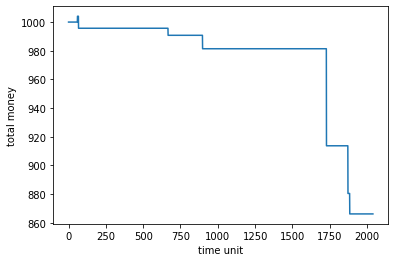

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(env.money_memory)
plt.xlabel("time unit")
plt.ylabel("total money")

501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


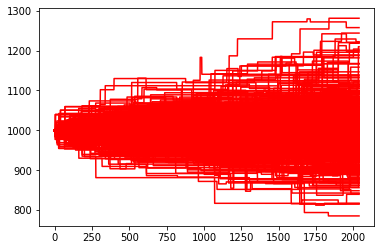

In [13]:
for episode in range(501,1001):
    obs = env.reset()

    for step in range(2100):
        epsilon = max(epsilon - episode / 500, 0.01)
        obs, reward, done, info = trade_time_unit(env, obs, epsilon)
        if done:
            count +=1
            print(count)
            break
    training_step(batch_size)

model.save(".\DDQN_50episodes.h5")

In [14]:
env.money_memory

[1000,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207,
 1008.207

In [15]:
env.money_memory[-1]

900.9

Text(0, 0.5, 'total money')

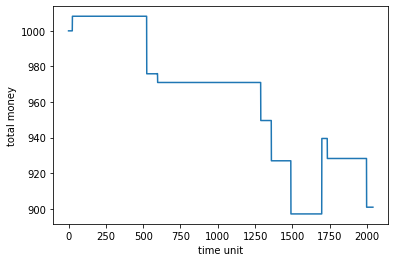

In [16]:
plt.plot(env.money_memory)
plt.xlabel("time unit")
plt.ylabel("total money")

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200


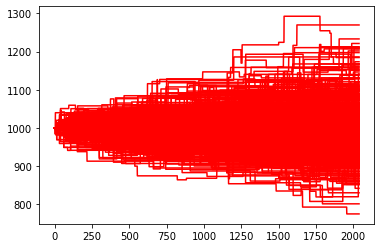

In [17]:
for episode in range(1001,1501):
    obs = env.reset()

    for step in range(2100):
        epsilon = max(epsilon - episode / 500, 0.01)
        obs, reward, done, info = trade_time_unit(env, obs, epsilon)
        if done:
            count +=1
            print(count)
            break
    training_step(batch_size)

model.save(".\DDQN_50episodes.h5")

In [18]:
env.money_memory

[1000,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 10

In [19]:
env.money_memory[-1]

907.2

1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700


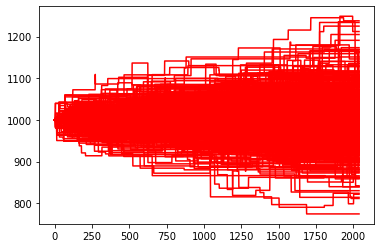

In [20]:
for episode in range(1501,2001):
    obs = env.reset()

    for step in range(2100):
        epsilon = max(epsilon - episode / 500, 0.01)
        obs, reward, done, info = trade_time_unit(env, obs, epsilon)
        if done:
            count +=1
            print(count)
            break
    training_step(batch_size)

model.save(".\DDQN_50episodes.h5")

In [21]:
env.money_memory

[1000,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 10

In [22]:
env.money_memory[-1]

995.615

Text(0, 0.5, 'total money')

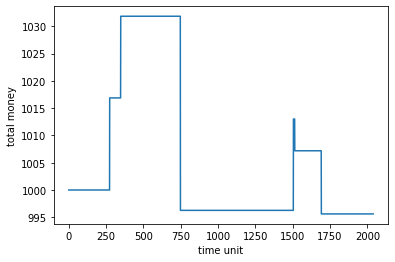

In [23]:
plt.plot(env.money_memory)
plt.xlabel("time unit")
plt.ylabel("total money")